## Artificial Intelligence Assignment 3
## No3. CNN3 Data Augmentation
## 20132651 Sungjae Lee

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_hflip = transforms.Compose([
    transforms.functional.hflip,
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 데이터 확대를 위해 transform 설정을 두 가지 형태로 생성합니다.
## 첫 번째는 기존의 방법과 동일한 transform_basic 이며, 두 번째는 hflip 을 적용한 transform 설정입니다. 
## hflip 을 데이터셋에 적용하기 위해서는 transforms.functional.hflip 을 추가하면 됩니다.
## 첫 번째 설정은 trainset_basic 과 testset 에 적용될 것이며,
## 두 번째 설정은 trainset_hflip 에 적용될 것입니다. trainset 들은 trainset_all 로 합쳐질 것입니다.

In [3]:

trainset_basic = torchvision.datasets.CIFAR10(root = './data', train = True,
                                             download = True, transform = transform_basic)

trainset_hflip = torchvision.datasets.CIFAR10(root = './data', train = True,
                                             download = True, transform = transform_hflip)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_basic)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset_all = torch.utils.data.ConcatDataset([trainset_basic, trainset_hflip])

print(len(trainset_basic), '+', len(trainset_hflip))
print(len(trainset_all))

## 위에서 말한 대로 두 개의 학습 데이터를 ConcatDataset 을 이용하여 합칩니다.
## 그 결과 합쳐진 데이터셋의 크기는 5만 + 5만 = 10만개가 됩니다. 총 2배의 데이터 확대가 일어난 셈입니다.

50000 + 50000
100000


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
trainloader = torch.utils.data.DataLoader(trainset_all,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

## 10만개의 train 데이터와 1만개의 테스트 데이터를 데이터 로더 형태로 생성합니다.

In [6]:
## 정확하게 데이터가 horizontal flip 되었는지 확인하기 위해 이미지를 각각 출력해 봅니다.

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## hflip 한 데이터셋에 대해 trainloader 를 생성해 줍니다.
trainloader_hflip  = torch.utils.data.DataLoader(trainset_hflip,
                                                 batch_size=4,
                                                 shuffle=False,
                                                 num_workers=2)

 frog truck truck  deer


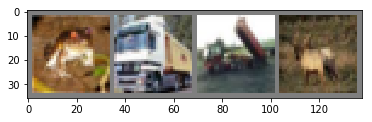

In [7]:
## 먼저 기존의 데이터 이미지를 출력해 봅니다.
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 frog truck truck  deer


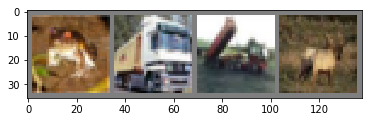

In [8]:
## 다음으로 hflip 된 이미지를 출력해 봅니다.

dataiter = iter(trainloader_hflip)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 정상적으로 hflip 을 이용하여 데이터가 확대되었음을 확인할 수 있습니다.
## 계속해서 해당 데이터를 이용한 신경망 학습을 진행합니다.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### (3) 화면 출력 확인 및 학습이 되고 있는지 서술

In [11]:
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss : %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

## 10만개의 학습 데이터로 데이터를 확대한 결과 25,000개의 배치가 생성되어 학습 시간도 2배로 증가하였습니다.
## 최종 loss 는 1.148 이며, 기존의 1.226에 비해 많은 데이터로 학습한 결과 성능이 조금 향상됨을 볼 수 있습니다.
## Adam Optimizer 를 적용하지 않았기 때문인지 초기 loss 의 감소가 2.300 -> 2.150 -> 1.964 로 더디게 감소합니다.
## 여전히 꾸준하게 loss가 감소하는 것으로 보아 적절하게 학습이 진행된다는 점을 확인할 수 있습니다.

[1,  1000] loss : 2.300
[1,  2000] loss : 2.150
[1,  3000] loss : 1.964
[1,  4000] loss : 1.838
[1,  5000] loss : 1.754
[1,  6000] loss : 1.681
[1,  7000] loss : 1.622
[1,  8000] loss : 1.593
[1,  9000] loss : 1.604
[1, 10000] loss : 1.557
[1, 11000] loss : 1.522
[1, 12000] loss : 1.489
[1, 13000] loss : 1.474
[1, 14000] loss : 1.455
[1, 15000] loss : 1.420
[1, 16000] loss : 1.435
[1, 17000] loss : 1.409
[1, 18000] loss : 1.385
[1, 19000] loss : 1.340
[1, 20000] loss : 1.337
[1, 21000] loss : 1.378
[1, 22000] loss : 1.365
[1, 23000] loss : 1.326
[1, 24000] loss : 1.329
[1, 25000] loss : 1.316
[2,  1000] loss : 1.300
[2,  2000] loss : 1.308
[2,  3000] loss : 1.269
[2,  4000] loss : 1.307
[2,  5000] loss : 1.258
[2,  6000] loss : 1.242
[2,  7000] loss : 1.235
[2,  8000] loss : 1.221
[2,  9000] loss : 1.279
[2, 10000] loss : 1.240
[2, 11000] loss : 1.228
[2, 12000] loss : 1.197
[2, 13000] loss : 1.209
[2, 14000] loss : 1.202
[2, 15000] loss : 1.174
[2, 16000] loss : 1.201
[2, 17000] loss 

### (6) 화면 출력 확인 및 일반화 성능 서술

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images :%d %%'%(100 * correct / total))

## 10만개의 이미지 데이터로 학습한 모델로, 1만개의 테스트 이미지를 분류한 결과 59%의 성능을 얻었습니다.
## 이는 기존의 55% 보다 4%정도 향상된 성능이라는 점에서 데이터 확대가 의미있다는 것을 볼 수 있습니다.
## 현재는 hflip 만 사용하여 데이터 확대를 진행했지만, 다양한 확대를 통해 더 좋은 결과를 얻을 수 있을것으로 보입니다.

Accuracy of the network on the 10000 test images :59 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

### (7) 화면 출력 확인 및 부류별 분류기의 성능 서술

In [14]:
## 앞에서와 마찬가지로 dog, cat, bird 등에서 낮은 성능을, ship, horse, car 등에서 높은 성능을 보입니다.
## dog 와 bird 개체의 판별력이 34, 44%로 약간 향상되었다는 점을 확인할 수 있습니다.
## 그 외에는 크게 변화가 없다고 말할 수 있습니다.

for i in range(10):
    print('Accuracy of %5s: %2d %%'%(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 57 %
Accuracy of   car: 78 %
Accuracy of  bird: 44 %
Accuracy of   cat: 45 %
Accuracy of  deer: 50 %
Accuracy of   dog: 34 %
Accuracy of  frog: 63 %
Accuracy of horse: 77 %
Accuracy of  ship: 80 %
Accuracy of truck: 63 %
